De gekozen dataset is afkomstig van [de University of Colorado, Irvine](https://archive.ics.uci.edu/dataset/571/hcv+data). Dezelfde dataset is gebruikt in een wetenschappelijk artikel, namelijk "Using machine learning techniques to generate laboratory diagnostic pathways—a case study" door Hoffman et al. (2018) en werd gepubliceerd in "Journal of Laboratory and Precision Medicine". 

De dataset gaat over patiënten met een leveraandoening, Hepatitis C. De data bestaat uit een groep gezonde proefpersonen en een groep patiënten met leveraandoeningen. De dataset bestaat uit 14 kolommen, waarbij 4 kolommen gaan over de patiënt (geslacht, leeftijd, gezond/ziek en ID) en 10 kolommen gaan over de waardes van de uitgevoerde laboratoriumtesten. Er is data van 615 patiënten. 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

We beginnen met het inlezen van de data. Deze wordt omgezet in een pandas DataFrame, zodat we een makkelijk overzicht hebben van de data.

In [4]:
hepatitis_c_csv = "HepatitisCdata.csv"

hepatitis_data = pd.read_csv(hepatitis_c_csv, sep=',', header=0)
hepatitis_data.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


Vervolgens wordt er aan de hand van de dataset een codebook gemaakt, zodat duidelijk is welke units worden gebruikt en wat de afkortingen van de testen betekenen. De dataset bestaat enkel uit patienteninformatie en laboratoriumtesten, deze gaan we allemaal meenemen om later uit te zoeken welke waarden mogelijk gecorreleerd zijn. Aan de hand daarvan gaan we kijken welke bloedwaarden het meeste zeggen over een Hepatitis C infectie.

In [5]:
codebook = {
    "attribute": ["ID", "Category", "Age", "Sex", "ALB", "ALP", "ALT", "AST", "BIL", "CHE", "CHOL", "CREA", "GGT", "PROT"],
    "unit": ["a.u.", "n.a.", "years", "a.u.", "a.u.", "a.u.", "a.u.", "a.u.", "a.u.", "a.u.", "a.u.", "a.u.", "a.u.", "a.u."],
    "dtype": ["integer", "category", "integer", "category", "float", "float", "float", "float", "float", "float", "float", "float", "float", "float",],
    "description": [
        "Patient ID",
        "Diagnosis (0=Blood Donor, 0s=suspect Blood Donor, 1=Hepatitis, 2=Fibrosis, 3=Cirrhosis)",
        "Age",
        "Sex (M/F)",
        "Albumin",
        "Alkaline phosphatase",
        "Alanine aminotransferase",
        "Aspartate aminotransferase",
        "Bilirubin",
        "Cholinesterase",
        "Cholesterol",
        "Creatinine",
        "Gamma-glutamyltransferase",
        "Protein"
    ]
}

pd.DataFrame(codebook).set_index("attribute")

,unit,dtype,description
attribute,,,
ID,a.u.,integer,Patient ID
Category,n.a.,category,"Diagnosis (0=Blood Donor, 0s=suspect Blood Don..."
Age,years,integer,Age
Sex,a.u.,category,Sex (M/F)
ALB,a.u.,float,Albumin
ALP,a.u.,float,Alkaline phosphatase
ALT,a.u.,float,Alanine aminotransferase
AST,a.u.,float,Aspartate aminotransferase
BIL,a.u.,float,Bilirubin


We weten uit hoeveel rijen en kolommen de dataset bestaat, om zeker te weten of we de data volledig hebben ingeladen controleren we dit eerst nog even.

In [4]:
hepatitis_data.shape

(615, 14)

Conclusie:
De data is volledig ingeladen en klaar voor de Exploratory Data Analysis.

In [6]:
pd.DataFrame({"is na": hepatitis_data.isna().sum()}).T

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
is na,0,0,0,0,1,18,1,0,0,0,10,0,0,1


Aan deze tabel is te zien hoeveel missing instances er zijn. Maar 5 kolommen missen data, namelijk ALB, ALP, ALT, CHOl en PROT. Daarvan missen ALB, ALT en PROT alle drie maar één instance. CHOL mist 10 instances en ALP mist er 18. Deze aantallen vallen mee op het totaal van 615. 

In [7]:
hepatitis_data.describe()

,Unnamed: 0,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,308.000000,47.408130,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,177.679487,10.055105,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,1.000000,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,154.500000,39.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,308.000000,47.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,461.500000,54.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,615.000000,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


Per kolom laat deze tabel zien wat het gemiddelde, het totaal etc. per kolom is. 
Omdat de kolom 'Unnamed' niet van belang is voor de EDA, wordt deze eruit gehaald. 

In [8]:
hepatitis_data.drop(hepatitis_data.columns[0], axis=1, inplace=True)

Om te controleren of dat goed is gegaan, wordt de dataset nog eens aangeroepen:

In [9]:
hepatitis_data

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,3=Cirrhosis,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,3=Cirrhosis,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
612,3=Cirrhosis,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
613,3=Cirrhosis,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


Er is te zien dat er nu nog maar 13 kolommen zijn in plaats van 14. Nu de patient ID's uit de dataset zijn gehaald, kan er verder gegaan worden.

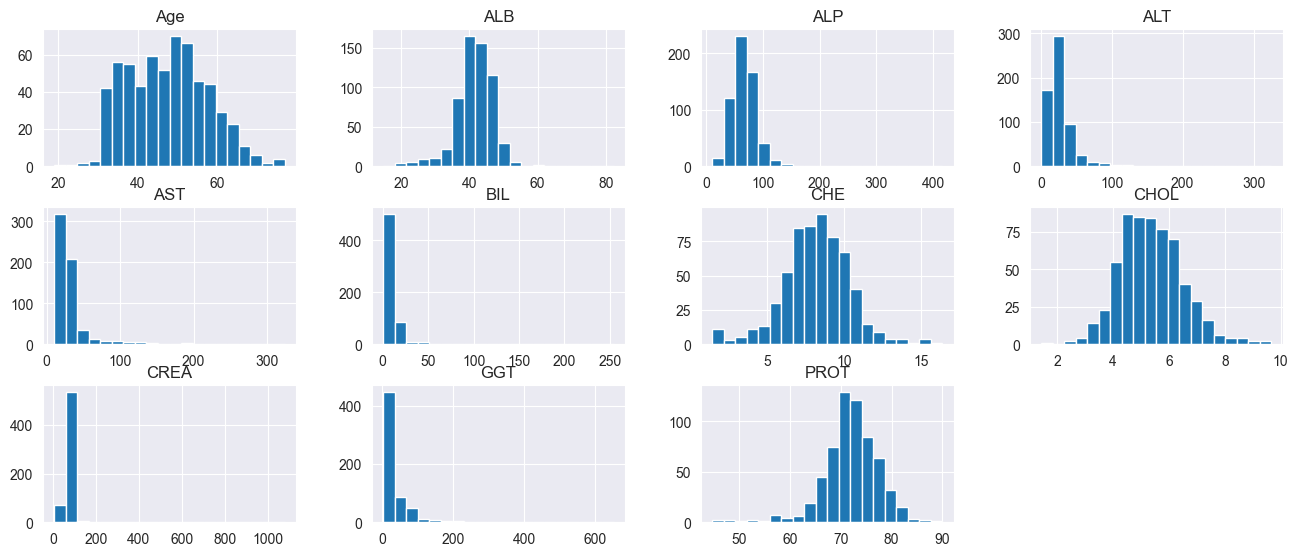

In [10]:
hepatitis_data.hist(bins=20, layout=(3, 4), figsize=(16.0, 6.4));

Te zien is dat age, ALB, CHE, CHOL en PROT redelijk normaal verdeeld zijn, de resterende waardes zijn veel schever verdeeld. Dit zou mogelijk kunnen komen door outliers. 

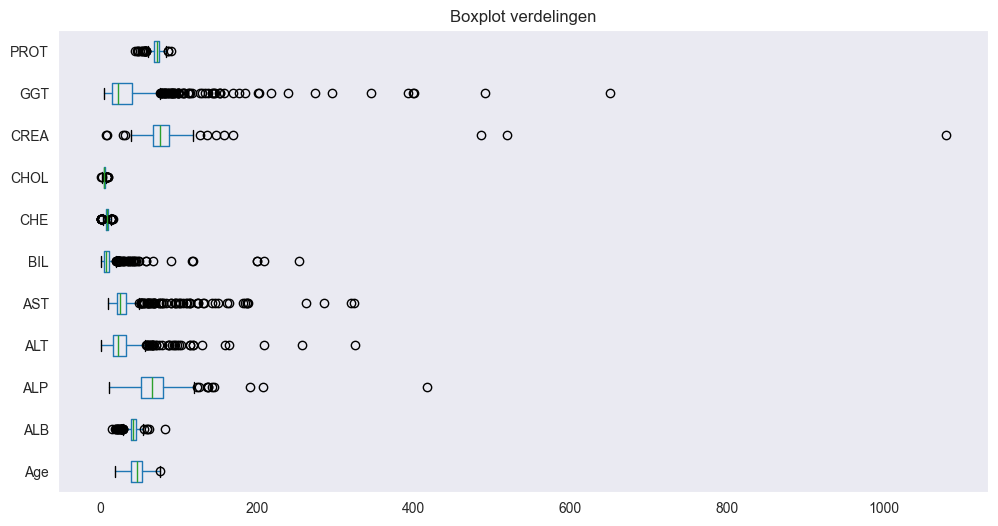

In [11]:
axs = hepatitis_data.boxplot(grid=False, vert=False, figsize=(12.0, 6.0))
axs.set_title("Boxplot verdelingen");

Aan de boxplot zijn de verdelingen van de waarde te zien. Een aantal testen (bijvoorbeeld CREA) heeft hoge waardes, maar klinisch gezien zou dit prima kunnen passen bij de betreffende patiënt en hoeven dit niet direct outliers te zijn. Om deze reden worden deze waarden gewoon meegenomen in de verdere EDA.

Om te proberen de scheve verhoudingen wat te corrigeren, worden er logtransformaties toegepast. Om hier een visueel beeld bij te krijgen, worden er opnieuw histogrammen per plot getoond. 

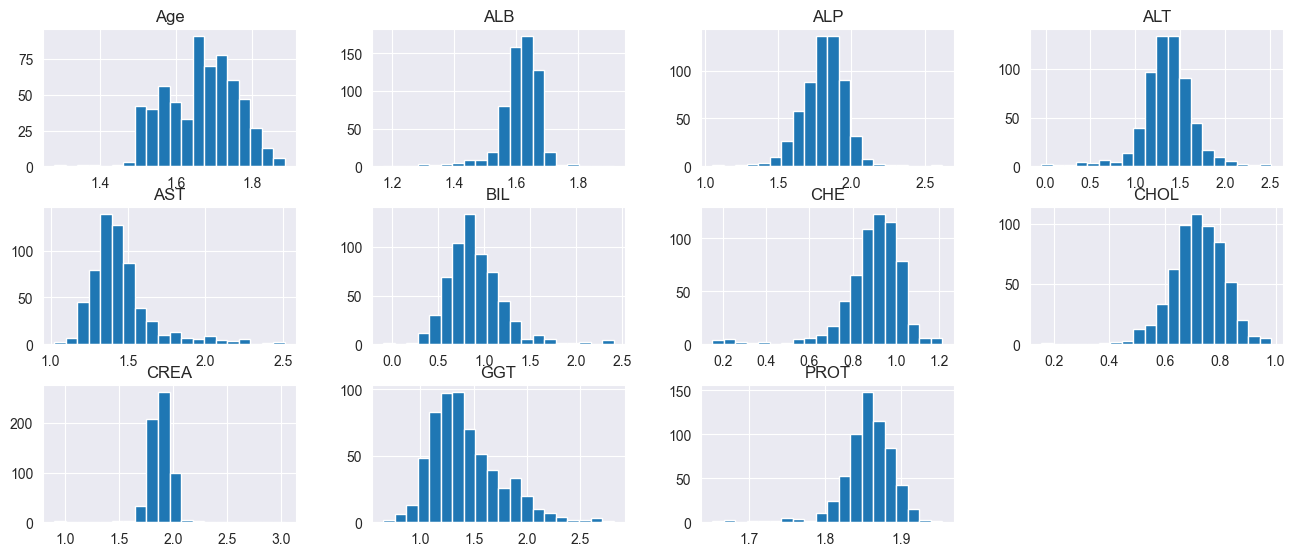

In [12]:
hepatitis_log = np.log10(hepatitis_data.select_dtypes('number'))

hepatitis_log.hist(bins=20, layout=(3, 4), figsize=(16.0, 6.4));

Te zien is dat de verdelingen na het uitvoeren van de logtransformatie normaler verdeeld zijn. We gaan hetzelfde doen met de boxplot.

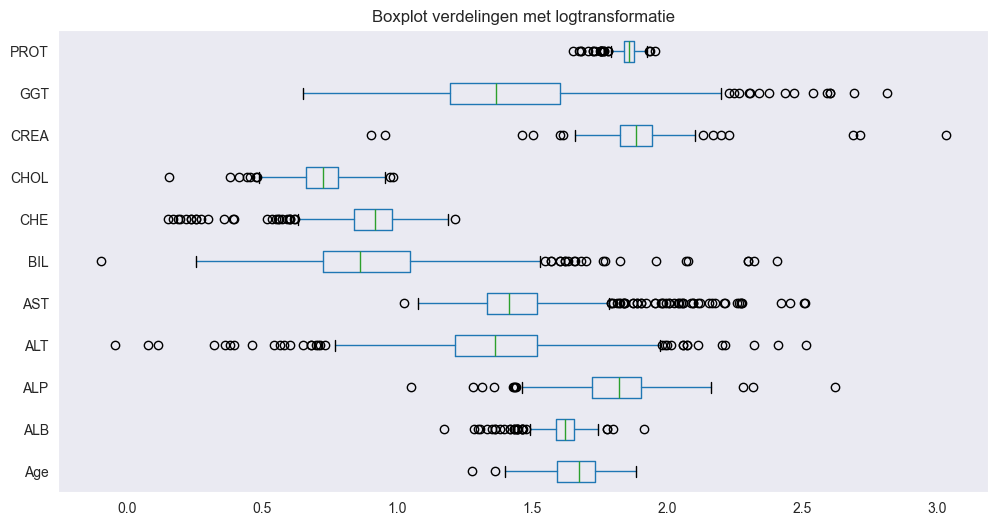

In [13]:
axs = hepatitis_log.boxplot(grid=False, vert=False, figsize=(12.0, 6.0))
axs.set_title("Boxplot verdelingen met logtransformatie");

Ook hier is te zien dat na de logtransformatie de data beter (normaler) verdeeld is. We gaan daarom door met de logaritmisch getransformeerde waardes.

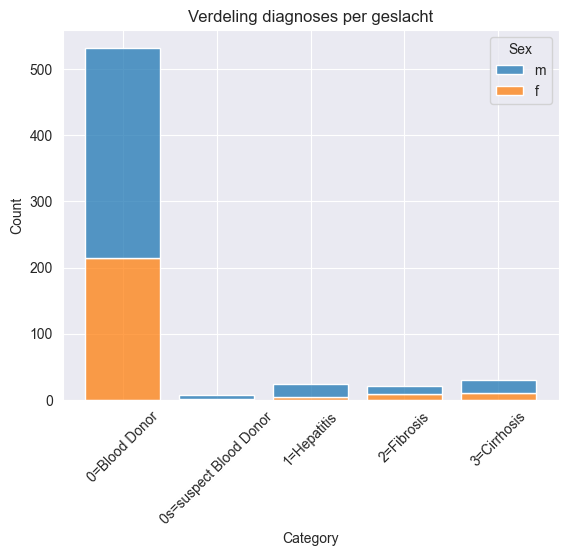

In [15]:
axs = sns.histplot(hepatitis_data, x="Category", hue="Sex", multiple="stack", shrink=0.8)
axs.set_title("Verdeling diagnoses per geslacht");
plt.xticks(rotation=45)

plt.show()

Aan het staafdiagram met "Verdeling diagnoses per geslacht" is te zien dat de dataset scheef verdeeld is. Het aantal gezonde patiënten (0=Blood Donor) bevat een veel groter aantal instances dan de aangedane groepen (1=Hepatitis, 2=Fibrosis en 3=Cirrhosis). Daarnaast is er nog de 0s=suspect Blood Donor groep, bestaande uit 7 instances. In zowel kaggle als het geciteerde artikel is niet te vinden wat deze groep patiënten een aparte groep maakt: het is niet duidelijk wat er anders is. Om deze reden zullen deze instances uit de dataset gehaald worden. Het toevoegen van de groep aan de 0=Blood Donor maakt het aantal negatieven enkel groter en het toevoegen van de groep aan 1, 2 of 3 maakt dat het machine learning algoritme later mogelijk foutieve uitslagen zal genereren. 

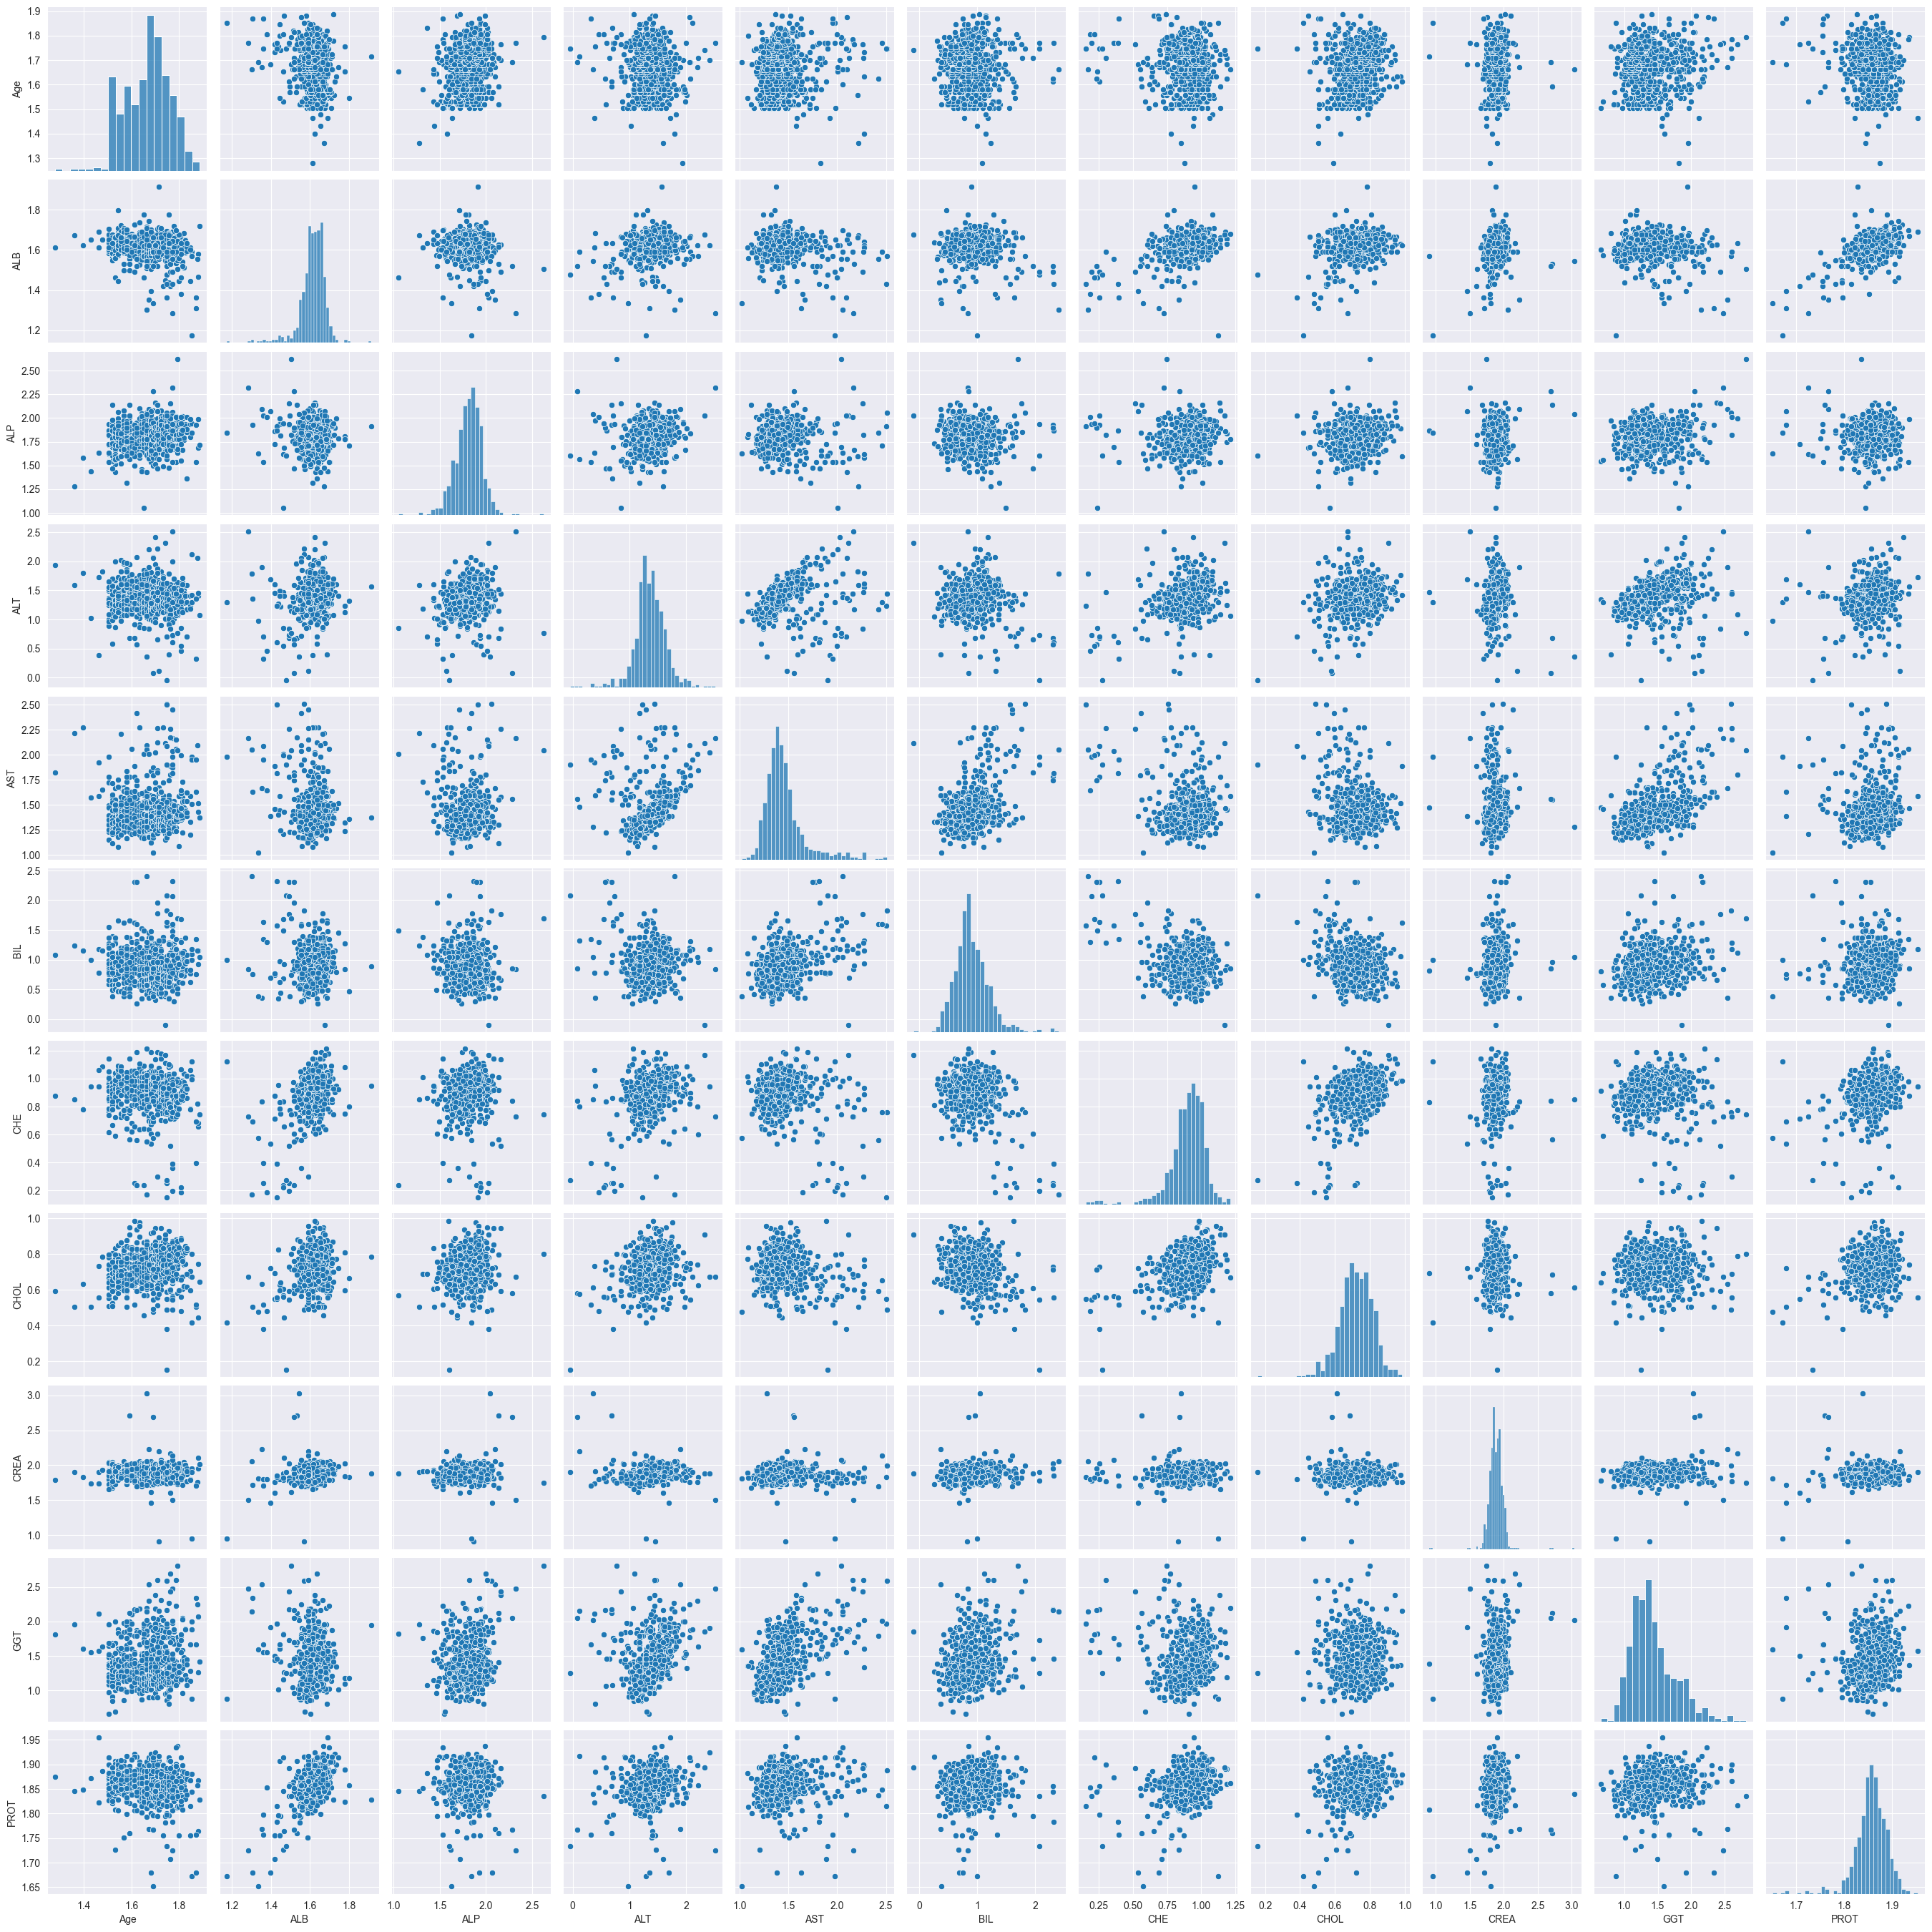

In [19]:
sns.pairplot(hepatitis_log);

Uit bovenstaande pairplot is een hoop informatie te halen. Zo is te zien dat de CREA correleert met geen enkele andere waarde. Dat is op zich logisch, omdat het geen echte leverparameter is. 

In [20]:
axs = sns.heatmap(hepatitis_data.corr(), annot=True, cmap="coolwarm", vmin=-1.0, vmax=1.0, square=True)
axs.set_title("Paarsgewijze correlaties ($R$)");

ValueError: could not convert string to float: '0=Blood Donor'